<a href="https://colab.research.google.com/github/ktquint/CE-439/blob/main/correction_de_sesgo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages('fuzzyjoin')
library(tidyverse)
library(fuzzyjoin)
library(tibble)
library(knitr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘stringdist’, ‘geosphere’




In [ ]:
# el formato de los archivos de geoglows es csv
archivos.csv <- list.files(pattern = "\\.csv$")
archivo.retrospectivo <- paste('./', archivos.csv[2], sep="")
archivo.pronostico <- paste('./', archivos.csv[1], sep="")

# el formato de usgs es txt
archivos.txt <- list.files(pattern = "\\.txt$")
archivo.usgs <- paste('./', archivos.txt[1], sep="")

In [ ]:
leer_usgs <- function(usgs.txt){
  # lee un archivo de usgs, borra datos irrelevantes, cambia los nombres, y adjusta el caudal a m^3/s
  read_table(usgs.txt) |>
    select(3:4) |>
    slice(29:n()) |>
    rename(Fecha=1, `Caudal (cfs)`=2) |>
    mutate(Fecha=as.Date(Fecha), Año = year(Fecha), Mes = month(Fecha), Día = day(Fecha)) |>
    mutate(`Caudal (m^3/s)` = as.numeric(`Caudal (cfs)`) / 35.315) |>
    drop_na()
}

leer_geoglows <- function(retro.csv){
  # lee un archivo de usgs, borra datos irrelevantes, y cambia los nombres
  read_csv(retro.csv) |>
    rename(`Caudal (m^3/s)`=2) |>
    mutate(Fecha=as.Date(time)) |>
    separate(time, into=c("Año", "Mes", "Día"), sep = "-") |>
    mutate(Mes=as.numeric(Mes)) |>
    drop_na()
}

# crear los data.frames
usgs <- leer_usgs(archivo.usgs)
geoglows <- leer_geoglows(archivo.retrospectivo)


Rows: 31047 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): 720237537
dttm (1): time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
“Removed 49675 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 49675 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 35542 rows containing missing values or values outside the scale range
(`geom_line()`).”


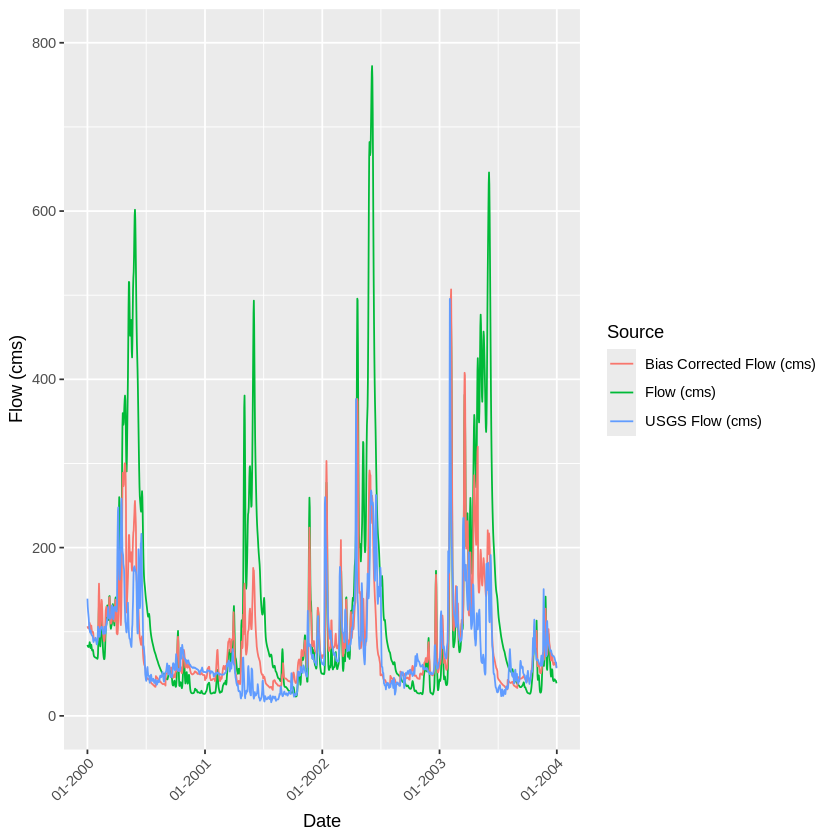

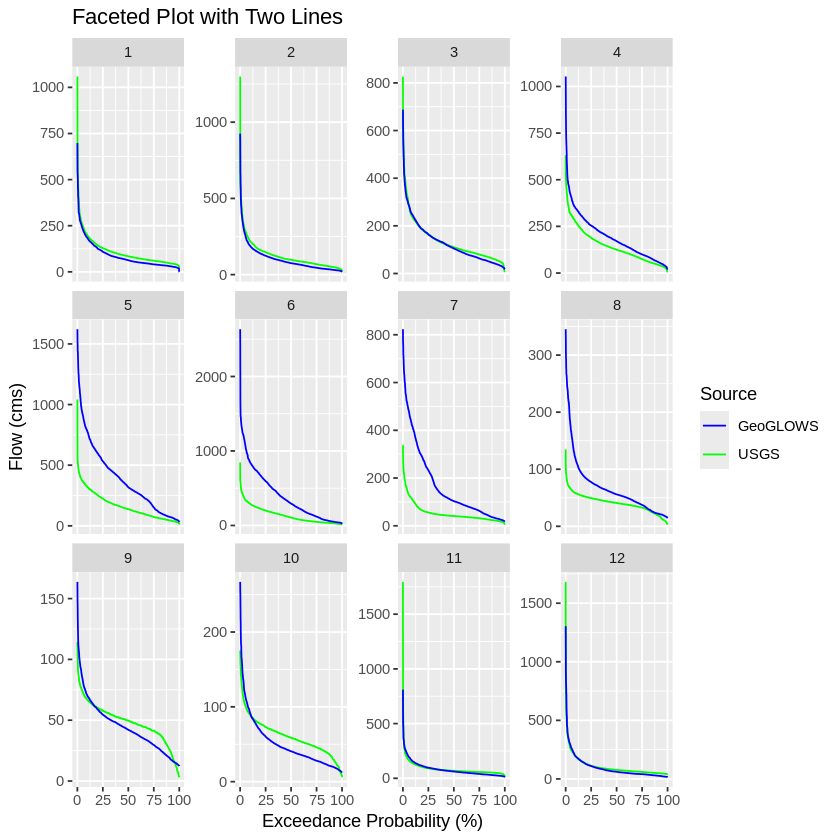

In [ ]:
bias.correction <- data.frame()
usgs.fdc <- data.frame()
geoglows.fdc <- data.frame()

for (i in 1:(length(monthly.usgs))) {
  usgs.month <- monthly.usgs[[i]] |>
    arrange(desc(`Flow (cms)`)) |>
    mutate(rank = 1:n()) |>
    mutate(EP = round(rank/n() * 100,2)) |>
    rename(`Bias Corrected Flow (cms)`=`Flow (cms)`)
  usgs.fdc <- usgs.fdc |>
    rbind(usgs.month |>
    rename(`Flow (cms)`=`Bias Corrected Flow (cms)`)) |>
    mutate(Date=as.Date(Date))

  geoglows.month <- monthly.geoglows[[i]] |>
    arrange(desc(`Flow (cms)`)) |>
    mutate(rank = 1:n()) |>
    mutate(EP = round(rank/n() * 100,2))
  geoglows.fdc <- geoglows.fdc |>
    rbind(geoglows.month) |>
    mutate(Date=as.Date(Date))

  monthly.bias <- difference_left_join(geoglows.month, usgs.month, by='EP', max_dist=0.03)
  bias.correction <- bias.correction |>
    rbind(monthly.bias)
}

bias.correction <- bias.correction |>
  select(`Date.x`, `Year.x`, `Month.x`, Day.x, `Flow (cms)`, `Bias Corrected Flow (cms)`) |>
  rename(Date=Date.x, Year=Year.x, Month=Month.x, Day=Day.x) |>
  arrange(Date)

Warning message:
“Removed 49675 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 49675 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 35542 rows containing missing values or values outside the scale range
(`geom_line()`).”


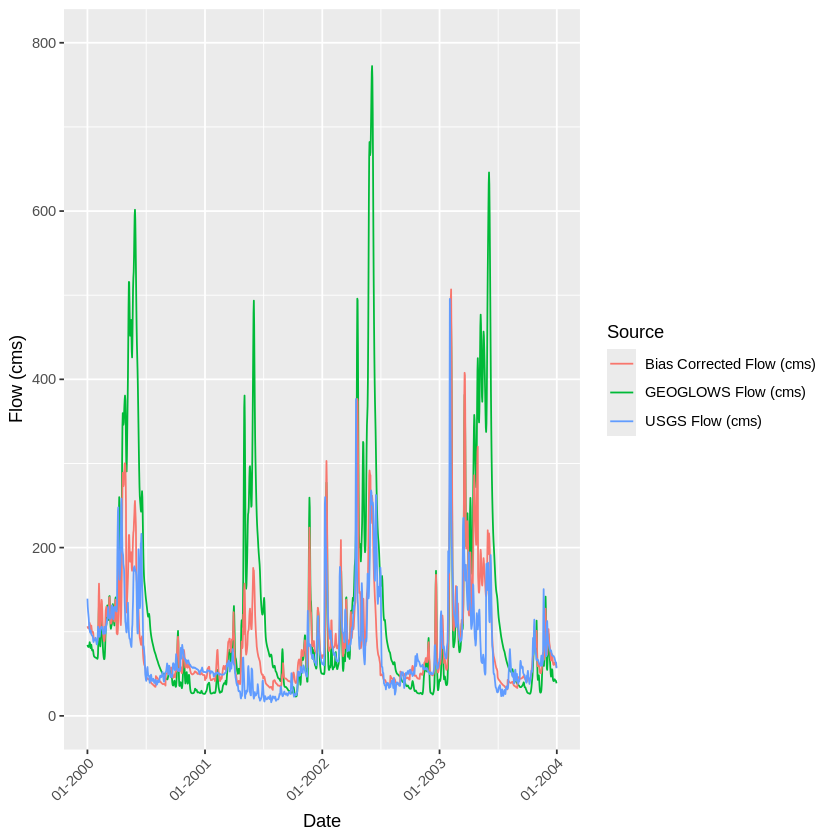

In [ ]:
duracion.caudal <- function(daily.flows){
  # splits a tibble of daily flows into a list of tibbles based on month
  monthly.data <- daily.flows |>
    group_by(Mes) |>
    group_split()
  # makes an empty dataframe that will be filled with monthly flow-duration curves
  fdc <- data.frame()
  for (i in 1:12){
    monthly.fdc <- monthly.data[[i]] |>
      arrange(desc(`Caudal (m^3/s)`)) |>
      mutate(rank = 1:n()) |>
      mutate(P.exc = round(rank/n() * 100,2))
    fdc <- fdc |>
      bind_rows(monthly.fdc)
  }
  # returns a list of fdcs... it will be easier to use the bias.correct function this way
  fdc |>
    group_by(Mes) |>
    group_split()
}


corregir.sesgo <- function(geoglows.data, usgs.data){
  # crea los
  usgs.cdc <- duracion.caudal(usgs.data)
  geoglows.cdc <- duracion.caudal(geoglows.data)
  bias.corrected <- data.frame()
  for (i in 1:12){
    monthly.bias <- difference_left_join(geoglows.cdc[[i]], usgs.cdc[[i]], by='P.exc', max_dist=0.03)
    bias.corrected <- bias.corrected |>
      rbind(monthly.bias)
  }
  # selecciona las columas de geoglows con los caudales corregidos
  bias.corrected |>
    select(`Fecha.x`, `Año.x`, `Mes.x`, Día.x, `Caudal (m^3/s).x`, `Caudal (m^3/s).y`, `P.exc.y`) |>
    rename(Fecha=Fecha.x, Año=Año.x, Mes=Mes.x, Día=Día.x,
           `Caudal (m^3/s)`= `Caudal (m^3/s).x`, `Caudal Corregido (m^3/s)`= `Caudal (m^3/s).y`, P.exc=P.exc.y) |>
    distinct(Mes, Día, Año, .keep_all = TRUE) |>
    arrange(Fecha)
}

# estas curvas de duración de caudal se trazará más adelante
usgs.cdc <- bind_rows(duracion.caudal(usgs))
geoglows.cdc <- bind_rows(duracion.caudal(geoglows))
# estos datos corregidos serán trazados también
correccion.de.sesgo <- corregir.sesgo(geoglows,usgs)

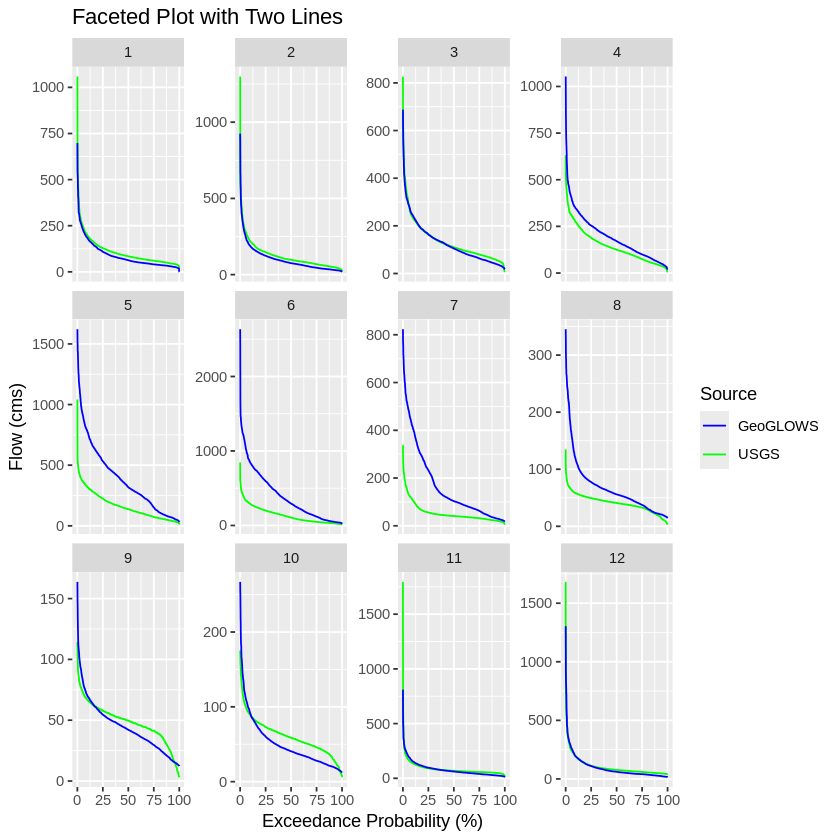

In [ ]:

# una gráfica de los caudales de usgs, geoglows, y la corrección de sesgo
ggplot() +
  geom_line(data = correccion.de.sesgo, aes(x = Fecha, y = `Caudal (m^3/s)`, color = "GEOGLOWS")) +
  geom_line(data = correccion.de.sesgo, aes(x = Fecha, y = `Caudal Corregido (m^3/s)`, color = "Corrección de Sesgo")) +
  geom_line(data = usgs, aes(x = Fecha, y = `Caudal (m^3/s)`, color = "USGS")) +
  coord_cartesian(ylim = c(0, 800)) +
  scale_x_date(limits = as.Date(c("2000-01-01", "2003-12-31")),
               date_breaks = "1 years", date_labels = "%m-%Y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Corrección de Caudales Retrospectivos", color = "Fuente de Datos", y = expression(paste("Caudal (m"^3,"/s)"))) +
  scale_color_manual(values = c("USGS" = "blue", "GEOGLOWS" = "red", "Corrección de Sesgo" = "green")) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))

# una gráfica de las curvas de duración de caudales
ggplot() +
  geom_line(data = usgs.cdc, aes(x = P.exc, y = `Caudal (m^3/s)`, color = "USGS")) +
  geom_line(data = geoglows.cdc, aes(x = P.exc, y = `Caudal (m^3/s)`, color = "GEOGLOWS")) +
  facet_wrap(~ Mes, scales = 'free_y') +
  labs(x = "Probabilidad de Excedencia (%)", y = expression(paste("Caudal (m"^3,"/s)")), title = "Curvas de Duración de Caudal", color = "Fuente de Datos") +
  scale_color_manual(values = c("USGS" = "blue", "GEOGLOWS" = "red")) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))

In [ ]:
forecast.correction <- function(forecast.csv, bias.correction){
  read_csv(forecast.csv) |>
    mutate(Año = year(datetime),
           Mes = month(datetime),
           Día = day(datetime),
           Hora = hour(datetime)) |>
    rename(`Caudal (m^3/s)`=flow_median) |>
    difference_left_join(correccion.de.sesgo, by=c('Mes', 'Caudal (m^3/s)'), max_dist=.43) |>
    select(Año.x, Mes.x, Día.x, Hora,
           `Caudal (m^3/s).x`,
           `Caudal Corregido (m^3/s)`) |>
    rename(Año=Año.x, Mes=Mes.x, Día=Día.x,
          `Caudal (m^3/s)`=`Caudal (m^3/s).x`) |>
    distinct(Mes, Día, Hora, .keep_all = TRUE) |>
    mutate(datetime=ISOdatetime(Año, Mes, Día, Hora, 0, 0))
  }

pronostico.corregido <- forecast.correction(archivo.pronostico, correccion.de.sesgo)

# una gráfica del pronóstico corregido y los caudales de GEOGLOWS
ggplot(data=pronostico.corregido) +
  geom_line(mapping=aes(x=datetime, y=`Caudal Corregido (m^3/s)`, color='Corrección de Sesgo')) +
  geom_line(mapping=aes(x=datetime, y=`Caudal (m^3/s)`, color = 'GEOGLOWS')) +
  labs(x = "Fecha", y = expression(paste("Caudal (m"^3,"/s)")), title = "Caudales Pronósticos Corregidos", color = "Fuente de Datos") +
  scale_color_manual(values = c("Corrección de Sesgo" = "green", "GEOGLOWS" = "red")) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5)) +
  ylim(0, NA)



|Source         | Mean Flow (cms)| Median Flow (cms)| Standard Deviation|
|:--------------|---------------:|-----------------:|------------------:|
|USGS           |             100|                70|                 86|
|GEOGLOWS       |             154|                79|                194|
|Bias Corrected |             103|                71|                 88|